Ok this time working with:  https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=SCZWZtKxObjh

This uses an old version of bert for tf v1...  using

https://pypi.org/project/bert-for-tf2/
and
https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [149]:
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow as tf

import pandas as pd
import numpy as np
import bert

import re
import random
import math
import hashlib
import time
import matplotlib


t0 = time.process_time()

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

t1 = time.process_time()
print("time: ",(t1-t0)*1000," ms." )

time:  0.17600000001039007  ms.


In [236]:
t0 = time.process_time()

# load the data
movie_reviews = pd.read_csv("/Users/druss/Downloads/IMDB Dataset.csv")
movie_reviews.shape

# preprocess the data
reviews = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

# get the labels...
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, movie_reviews['sentiment'])))

# tokenzize the data...
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

# create a function for tokenizing reviews...
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

tokenized_reviews = [tokenize_reviews(review) for review in reviews]

random.seed(4);
reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]
random.shuffle(reviews_with_len)

reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

#processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))
#BATCH_SIZE = 32
#batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

#TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
#TEST_BATCHES = TOTAL_BATCHES // 10
#batched_dataset.shuffle(TOTAL_BATCHES)
#test_data = batched_dataset.take(TEST_BATCHES)
#train_data = batched_dataset.skip(TEST_BATCHES)


zz=pd.DataFrame( {
    "text":pd.Series(reviews), 
    "tokens":pd.Series(tokenized_reviews), 
    "label":pd.Series(y)
})
zz["len"] = [ len(x) for x in zz["tokens"] ]

# split the data into Train/test based on the md5 hash...
zz["hash"] = [ hashlib.md5(x.encode('ascii')).hexdigest() for x in zz["text"] ]
zz["Test"] = [ (int(x,16) % 100 > 90) for x in zz["hash"]]
train_data = zz[zz["Test"] != True].copy()
test_data = zz[zz["Test"] == True].copy()
print(train_data.shape)
print(test_data.shape)

t1 = time.process_time()
print("time: ",(t1-t0)," sec" )

(45380, 6)
(4620, 6)
time:  166.75956399999995  sec


Ok following the step in BertTake2,  we are now at the point where we are ready to build models

Filter both the training/testing data so that no input has more than 300 tokens...
300 was chosen be 75% of the Test/Train data has less than 300 tokens.

consider truncating the tokens to the first 300...

count    45380.000000
mean       236.185963
std        177.779214
min          6.000000
25%        127.000000
50%        176.000000
75%        286.000000
max       2615.000000
Name: len, dtype: float64

,text,tokens,label,len,hash,Test
6,I sure would like to see resurrection of up da...,"[1045, 2469, 2052, 2066, 2000, 2156, 15218, 19...",1,155,c5c4cf73513dcc56ffa4407cb8f122a4,True
42,Of all the films have seen this one The Rage h...,"[1997, 2035, 1996, 3152, 2031, 2464, 2023, 202...",0,176,918df352afa5d7e2a748646b72ce60a7,True
49,Average and surprisingly tame Fulci giallo whi...,"[2779, 1998, 10889, 24763, 11865, 15472, 2072,...",0,109,a413870abe8e351ce249fe335d9f49c3,True
63,Besides being boring the scenes were oppressiv...,"[4661, 2108, 11771, 1996, 5019, 2020, 28558, 1...",0,52,d6a8db3df658403e551729e62e252449,True
70,Caddyshack Two is good movie by itself but com...,"[28353, 5149, 7377, 3600, 2048, 2003, 2204, 31...",0,244,c88650c3f57fa56441954230f7f6bfd1,True
...,...,...,...,...,...,...
49959,My thoughts on the movie It was not good not g...,"[2026, 4301, 2006, 1996, 3185, 2009, 2001, 202...",0,600,990a38643201beeec2f631f932a1089d,True
49963,If you like really shocking movies this is for...,"[2065, 2017, 2066, 2428, 16880, 5691, 2023, 20...",0,65,6ef33ea069803a156c0b36352559a890,True
49964,I saw this last week during Bruce Campbell boo...,"[1045, 2387, 2023, 2197, 2733, 2076, 5503, 606...",1,227,8f36c2e162da5eadbbc0e7e6046b869b,True
49983,I loved it having been fan of the original ser...,"[1045, 3866, 2009, 2383, 2042, 5470, 1997, 199...",1,127,d365dcede861bf5ae05584760b70388d,True


count    4620.000000
mean      239.057143
std       182.112432
min        17.000000
25%       127.000000
50%       176.000000
75%       291.250000
max      1768.000000
Name: len, dtype: float64

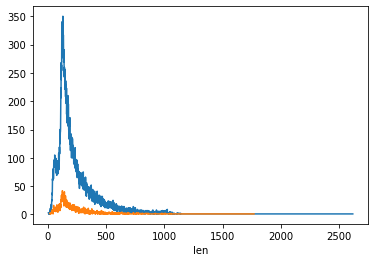

In [237]:
tmp = train_data.groupby("len").size()
display(train_data["len"].describe())
display(tmp.plot())


display(test_data)
tmp1 = test_data.groupby("len").size()
display(test_data["len"].describe())
tmp1.plot()

In [257]:
pd.DataFrame( {
    "text":pd.Series(reviews), 
    "tokens":pd.Series(tokenized_reviews), 
    "label":pd.Series(y)
})
zz["len"] = [ len(x) for x in zz["tokens"] ]

# split the data into Train/test based on the md5 hash...
zz["hash"] = [ hashlib.md5(x.encode('ascii')).hexdigest() for x in zz["text"] ]
zz["Test"] = [ (int(x,16) % 100 > 90) for x in zz["hash"]]
train_data = zz[zz["Test"] != True].copy()
test_data = zz[zz["Test"] == True].copy()
print(train_data.shape)
print(test_data.shape)

train_data.iloc[0,0]="howdy"
train_data

(45380, 6)
(4620, 6)


,text,tokens,label,len,hash,Test
0,howdy,"[2028, 1997, 1996, 2060, 15814, 2038, 3855, 20...",1,318,224a45b0a0587058260659bca7e5e017,False
1,A wonderful little production The filming tech...,"[1037, 6919, 2210, 2537, 1996, 7467, 6028, 200...",1,167,eb34a11df84804f9e8a12566067b7b77,False
2,I thought this was wonderful way to spend time...,"[1045, 2245, 2023, 2001, 6919, 2126, 2000, 524...",1,163,d8c0c80ad211ed7b4b7546ba2fd91d13,False
3,Basically there a family where little boy Jake...,"[10468, 2045, 1037, 2155, 2073, 2210, 2879, 51...",0,129,f096d3e60f0c1cd633775dae69ddbcd8,False
4,Petter Mattei Love in the Time of Money is vis...,"[9004, 3334, 4717, 7416, 2293, 1999, 1996, 205...",1,238,19bc24809030f3a49fc100d06f609d1a,False
...,...,...,...,...,...,...
49995,I thought this movie did down right good job I...,"[1045, 2245, 2023, 3185, 2106, 2091, 2157, 220...",1,187,4e436d62ebd850a3736f09cbf403f2e2,False
49996,Bad plot bad dialogue bad acting idiotic direc...,"[2919, 5436, 2919, 7982, 2919, 3772, 10041, 25...",0,117,ac57048252a834440dbb2d35e6909b4e,False
49997,I am Catholic taught in parochial elementary s...,"[1045, 2572, 3234, 4036, 1999, 28773, 4732, 28...",0,227,5318d6a40115c8ed55525990d91aac89,False
49998,I going to have to disagree with the previous ...,"[1045, 2183, 2000, 2031, 2000, 21090, 2007, 19...",0,242,43ea31cbfa56a3b0c429caae95a244c5,False


In [235]:
#train_data = train_data[ train_data["len"] < 300]
#test_data = test_data[ test_data["len"]<300]
train_data = zz[zz["Test"] != True].copy()
test_data = zz[zz["Test"] == True].copy()

def addSpecialTokens(lst,maxValues):
    lst=lst[:maxValues-3]
    lst.insert(0,101)
    lst.append(102)

##test_data["tokens"].apply(lambda x:x.insert(0,1))
test_data["tokens"].apply(addSpecialTokens,args=(300,))



0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
49995   NaN
49996   NaN
49997   NaN
49998   NaN
49999   NaN
Name: Test, Length: 50000, dtype: float64

In [151]:
t0 = time.process_time()
model_dir = "/Users/druss/Downloads/uncased_L-12_H-768_A-12"

bert_params = bert.params_from_pretrained_ckpt(model_dir)
l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")

t1 = time.process_time()
print("time: ",(t1-t0)," sec" )

time:  0.00498800000002575  sec


In [154]:
t0 = time.process_time()

import os
from tensorflow import keras

max_seq_len = 300
l_input_ids      = keras.layers.Input(shape=(max_seq_len,), dtype='int32')
l_token_type_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32')

# using the default token_type/segment id 0
output = l_bert(l_input_ids)                              # output: [batch_size, max_seq_len, hidden_size]
model = keras.Model(inputs=l_input_ids, outputs=output)
model.build(input_shape=(None, max_seq_len))

bert_ckpt_file   = os.path.join(model_dir, "bert_model.ckpt")
bert.load_stock_weights(l_bert, bert_ckpt_file)

t1 = time.process_time()
print("time: ",(t1-t0)," sec" )

Done loading 196 BERT weights from: /Users/druss/Downloads/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x6a9a18450> (prefix:bert_5). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
time:  3.6569389999999657  sec


ok, we now have the pretrained bert model loaded...  we need get the input in a format bert can ingest.  We need masks to ignore tokens in the sentence that are longer than the max seq length. (which we define in the cell above as 300)


In [180]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [190]:
get_ids(["CLS"],BertTokenizer,10)

TypeError: convert_tokens_to_ids() missing 1 required positional argument: 'tokens'

In [198]:
print(tokenizer.convert_tokens_to_ids(tokens=["[CLS]","[SEP]"]))
train_data["tokens"].apply(lambda x:x.insert(0,102))

train_data["tokens"]

[101, 102]


1        [102, 1037, 6919, 2210, 2537, 1996, 7467, 6028...
2        [102, 1045, 2245, 2023, 2001, 6919, 2126, 2000...
3        [102, 10468, 2045, 1037, 2155, 2073, 2210, 287...
4        [102, 9004, 3334, 4717, 7416, 2293, 1999, 1996...
5        [102, 2763, 2026, 2035, 2051, 5440, 3185, 2466...
                               ...                        
49995    [102, 1045, 2245, 2023, 3185, 2106, 2091, 2157...
49996    [102, 2919, 5436, 2919, 7982, 2919, 3772, 1004...
49997    [102, 1045, 2572, 3234, 4036, 1999, 28773, 473...
49998    [102, 1045, 2183, 2000, 2031, 2000, 21090, 200...
49999    [102, 2053, 2028, 24273, 1996, 2732, 10313, 56...
Name: tokens, Length: 34829, dtype: object